In [3]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from sklearn.datasets import fetch_rcv1
rcv1 = fetch_rcv1()
X = rcv1.data
y = rcv1.target

In [6]:
import pandas as pd
X_train_ = pd.DataFrame(X[:5000].todense()) # use the first 5000 data
y_train_ = pd.DataFrame(y[:5000].todense())

In [7]:
# Convert dataframe to numpy array
X_train = X_train_.to_numpy()
y_train = y_train_.to_numpy()


In [8]:
# To torch tensor
X_train = torch.tensor(X_train, dtype = torch.float32).to(device)
y_train = torch.tensor(y_train, dtype = torch.float32).to(device)

# Hyper Parameters

In [9]:
SARAH_lr = 0.1
SVRG_lr = 0.1
alpha = 0.1 # Ragularized parameter

In [10]:
def softmax(x):
    exp_x = torch.exp(x - torch.max(x))
    return exp_x / exp_x.sum(axis=-1, keepdims=True)


def grad_cross_entropy_regularized_single(data, w, target):

    y = data @ w
    z = softmax(y)
    # print(data.shape, w.shape, target.shape, z.shape)
    grad_loss = torch.outer(data, (z - target))
    grad_reg = 2 * alpha * w

    return grad_loss + grad_reg

def grad_cross_entropy_regularized_full(data, w, target):
    grad = np.zeros(w.shape) # w shape = (n_features, n_classes)
    grad = torch.tensor(grad, dtype = torch.float32).to(device)
    for i in range(data.shape[0]):
        grad += grad_cross_entropy_regularized_single(data[i], w, target[i])
    return grad / data.shape[0]

# SVRG - Multi Outerloops

In [11]:
track_v_SVRG = []
passes_SVRG = []
n_classes = y_train.shape[1]
w_tilde = np.zeros((X_train.shape[1], n_classes)) # starting point
w_tilde = torch.tensor(w_tilde, dtype = torch.float32).to(device)
outer_iter = 10
inner_iter = 10000
next_w_tilde = w_tilde
cnt = 0

for s in range(outer_iter):
    w_tilde = next_w_tilde.clone()
    w_0 = w_tilde.clone()
    mu_tilde = grad_cross_entropy_regularized_full(X_train, w_tilde, y_train)
    track_v_SVRG.append(torch.linalg.norm(mu_tilde) ** 2)
    passes_SVRG.append(torch.linalg.norm(mu_tilde) ** 2)
    idx = np.random.randint(0, inner_iter)

    for t in range(inner_iter):
        i = np.random.randint(0, X_train.shape[0])
        v_t = (grad_cross_entropy_regularized_single(X_train[i], w_0, y_train[i]) - grad_cross_entropy_regularized_single(X_train[i], w_tilde, y_train[i]) + mu_tilde)
        w_1 = w_0 - SVRG_lr * v_t
        # w_tilde = w_1.clone()
        w_0 = w_1.clone()
        if t == idx:
            next_w_tilde = w_1.clone()
        track_v_SVRG.append(torch.linalg.norm(v_t) ** 2)
        cnt += 2
        if cnt >= X_train.shape[0]:
            passes_SVRG.append(torch.linalg.norm(v_t) ** 2)
            cnt = 0


# SARAH - Multi Outerloops

In [12]:
track_v_SARAH = []
n_classes = y_train.shape[1]
w = np.zeros((X_train.shape[1], n_classes)) # starting point
w = torch.tensor(w, dtype = torch.float32).to(device)
outer_iter = 10
inner_iter = 10000
passes_SARAH = []
cnt = 0
for s in range(outer_iter):
    w_0 = w.clone()
    v_0 = grad_cross_entropy_regularized_full(X_train, w_0, y_train)
    w_1 = w_0 - SARAH_lr * v_0
    track_v_SARAH.append(torch.linalg.norm(v_0) ** 2)
    idx = np.random.randint(0, inner_iter)
    passes_SARAH.append(torch.linalg.norm(v_0) ** 2)
    for t in range(inner_iter):
        i = np.random.randint(0, X_train.shape[0])
        v_0 = grad_cross_entropy_regularized_single(X_train[i], w_1, y_train[i]) - grad_cross_entropy_regularized_single(X_train[i], w_0, y_train[i]) + v_0
        w_0 = w_1.clone()
        w_1 = w_1 - SVRG_lr * v_0
        if t == idx:
            w = w_1.clone()
        track_v_SARAH.append(torch.linalg.norm(v_0) ** 2)
        cnt+=2
        if cnt >= X_train.shape[0]:
            passes_SARAH.append(torch.linalg.norm(v_0) ** 2)
            cnt = 0

In [13]:
track_v_SVRG = [t.cpu().tolist() for t in track_v_SVRG]
track_v_SARAH = [t.cpu().tolist() for t in track_v_SARAH]


In [16]:
passes_SVRG = [t.cpu().tolist() for t in passes_SVRG]
passes_SARAH = [t.cpu().tolist() for t in passes_SARAH]

# Plot

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot((track_v_SVRG[:]), marker='o', linestyle='-', color='b', linewidth=0.1, markersize=0.08, label='SVRG')
plt.plot((track_v_SARAH[:]), marker='o', linestyle='-', color='r', linewidth=0.1, markersize=0.08, label='SARAH')

plt.plot()
plt.title('rcv1')
plt.xlabel('Epochs')
plt.ylabel('||v_t||^2')
plt.ylim(1e-14, 9e-14)
plt.grid(True)
plt.legend()
plt.savefig('/content/figure2_multi.png')
plt.show()


In [58]:
from google.colab import files
files.download('/content/figure2_multi.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SVRG - Single Outerloop

In [59]:
track_v_SVRG = []
passes_SVRG = []
n_classes = y_train.shape[1]
w_tilde = np.zeros((X_train.shape[1], n_classes)) # starting point
w_tilde = torch.tensor(w_tilde, dtype = torch.float32).to(device)
outer_iter = 1
inner_iter = 10000
next_w_tilde = w_tilde
cnt = 0

for s in range(outer_iter):
    w_tilde = next_w_tilde.clone()
    w_0 = w_tilde.clone()
    mu_tilde = grad_cross_entropy_regularized_full(X_train, w_tilde, y_train)
    track_v_SVRG.append(torch.linalg.norm(mu_tilde) ** 2)
    passes_SVRG.append(torch.linalg.norm(mu_tilde) ** 2)
    idx = np.random.randint(0, inner_iter)

    for t in range(inner_iter):
        i = np.random.randint(0, X_train.shape[0])
        v_t = (grad_cross_entropy_regularized_single(X_train[i], w_0, y_train[i]) - grad_cross_entropy_regularized_single(X_train[i], w_tilde, y_train[i]) + mu_tilde)
        w_1 = w_0 - SVRG_lr * v_t
        # w_tilde = w_1.clone()
        w_0 = w_1.clone()
        if t == idx:
            next_w_tilde = w_1.clone()
        track_v_SVRG.append(torch.linalg.norm(v_t) ** 2)
        cnt += 2
        if cnt >= X_train.shape[0]:
            passes_SVRG.append(torch.linalg.norm(v_t) ** 2)
            cnt = 0

# SARAH - Single Outerloop

In [60]:
track_v_SARAH = []
n_classes = y_train.shape[1]
w = np.zeros((X_train.shape[1], n_classes)) # starting point
w = torch.tensor(w, dtype = torch.float32).to(device)
outer_iter = 1
inner_iter = 10000
passes_SARAH = []
cnt = 0
for s in range(outer_iter):
    w_0 = w.clone()
    v_0 = grad_cross_entropy_regularized_full(X_train, w_0, y_train)
    w_1 = w_0 - SARAH_lr * v_0
    track_v_SARAH.append(torch.linalg.norm(v_0) ** 2)
    idx = np.random.randint(0, inner_iter)
    passes_SARAH.append(torch.linalg.norm(v_0) ** 2)
    for t in range(inner_iter):
        i = np.random.randint(0, X_train.shape[0])
        v_0 = grad_cross_entropy_regularized_single(X_train[i], w_1, y_train[i]) - grad_cross_entropy_regularized_single(X_train[i], w_0, y_train[i]) + v_0
        w_0 = w_1.clone()
        w_1 = w_1 - SVRG_lr * v_0
        if t == idx:
            w = w_1.clone()
        track_v_SARAH.append(torch.linalg.norm(v_0) ** 2)
        cnt+=2
        if cnt >= X_train.shape[0]:
            passes_SARAH.append(torch.linalg.norm(v_0) ** 2)
            cnt = 0

In [61]:
track_v_SVRG = [t.cpu().tolist() for t in track_v_SVRG]
track_v_SARAH = [t.cpu().tolist() for t in track_v_SARAH]


In [119]:
passes_SVRG = [t.cpu().tolist() for t in passes_SVRG]
passes_SARAH = [t.cpu().tolist() for t in passes_SARAH]

# Plot

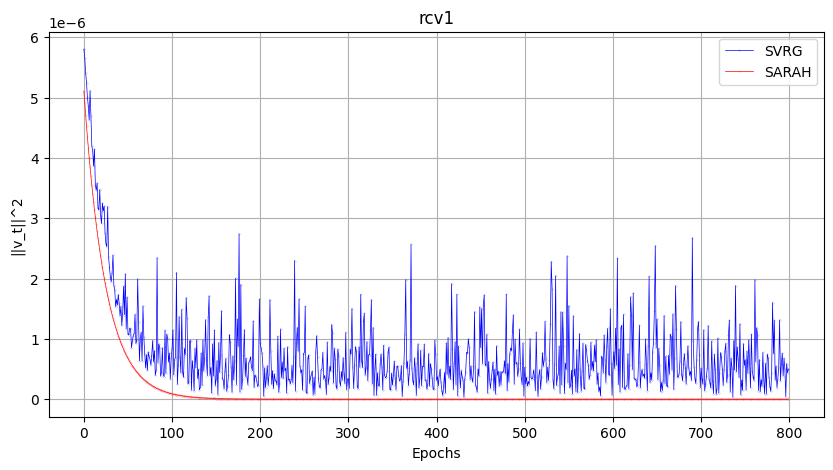

In [139]:
plt.figure(figsize=(10, 5))
plt.plot((track_v_SVRG[200:1000]), marker='o', linestyle='-', color='b', linewidth=0.5, markersize=0.1, label='SVRG')
plt.plot((track_v_SARAH[200:1000]), marker='o', linestyle='-', color='r', linewidth=0.5, markersize=0.1, label='SARAH')

plt.plot()
plt.title('rcv1')
plt.xlabel('Epochs')
plt.ylabel('||v_t||^2')
plt.grid(True)
plt.legend()
plt.savefig('/content/figure2_single.png')
plt.show()


In [140]:
files.download('/content/figure2_single.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>